In [123]:
# Import dependencies
import timeit
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [124]:
# Import Data
main_file_path = '../data/data_customer.csv'
data = pd.read_csv(main_file_path)

# print('Number of Samples: ', data.shape[0])
# print('Number of Attributes: ', data.shape[1]-1)
# data.head()

### Data Preprocessing

In [125]:
# Display Data types of each column
# data.dtypes

In [126]:
# Variable TotalCharges should be a continuous numeric data type rather than a discrete object data type
data.TotalCharges = pd.to_numeric(data.TotalCharges, errors='coerce')

# Check for NULL entries
# data.isnull().sum()

In [127]:
# Remove all entries that contain NULL
data.dropna(inplace=True)

# Remove customer ID
df = data.iloc[:,1:]

# Upsample
#https://chrisalbon.com/machine_learning/preprocessing_structured_data/handling_imbalanced_classes_with_upsampling/
# Indicies of each class' observations
i_class0 = np.where(df.Churn == 'Yes')[0]
i_class1 = np.where(df.Churn == 'No')[0]

# Number of observations in each class
n0 = len(i_class0)
n1 = len(i_class1)

# For every observation in class 1, randomly sample from class 0 with replacement
i_class0_upsampled = np.random.choice(i_class0, size=n1, replace=True)

# Join together class 0's upsampled target vector with class 1's target vector
i_upsampled = np.concatenate((i_class0_upsampled, i_class1))
df_upsampled = df.iloc[i_upsampled.tolist(),:]

# Separate X and Y
ydata = df.Churn #df_upsampled.Churn
xdata_raw = df.drop(['Churn'], axis=1) #df_upsampled.drop(['Churn'], axis=1)


# Convert Chrun into binary numeric variable
ydata.replace(to_replace='Yes', value=1, inplace=True)
ydata.replace(to_replace='No', value=0, inplace=True)

# Convert all categorial variables in xdata into dummy variables
xdata = pd.get_dummies(xdata_raw)



In [128]:
i_class0 = np.where(ydata == 0)[0]
i_class1 = np.where(ydata == 1)[0]
print("If choose 0 for all guesses: ", len(i_class0)/data.shape[0])

If choose 0 for all guesses:  0.7342150170648464


In [129]:
#Import train_test_split
from sklearn.model_selection import train_test_split

# Split data into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(xdata, ydata, test_size=.2, random_state=101)

In [130]:
# Scale all features from 0 to 1
from sklearn.preprocessing import MinMaxScaler

features = X_train.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train))
X_train.columns = features
X_test = pd.DataFrame(scaler.transform(X_test))
X_test.columns = features

X_train.head()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.0,0.014085,0.062874,0.004985,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.549296,0.237525,0.195898,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.042254,0.469062,0.025202,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.000000,0.368263,0.480083,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.985915,0.336826,0.432293,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


### Predictive Models - Parameter Tuning

In [139]:
from sklearn.model_selection import GridSearchCV

def grid_search(estimator, param_grid, X_train, y_train):
    grid = GridSearchCV(estimator, param_grid, cv=10, scoring='accuracy', return_train_score=True, n_jobs=-1)
    grid.fit(X_train, y_train)
    print(pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']])

    print()
    # examine the best model
    print('Best_score = ', grid.best_score_)
    print('Best_params = ', grid.best_params_)
    return grid

##### **Decision Tree**

In [140]:
from sklearn.tree import DecisionTreeClassifier

param_grid={
             'criterion': ["gini", "entropy"],
             'max_depth': list(range(1,20,2)),
           }

dtree_grid = grid_search(DecisionTreeClassifier(), param_grid, X_train, y_train)


    mean_test_score  std_test_score                                     params
0          0.730844        0.000593      {'criterion': 'gini', 'max_depth': 1}
1          0.786311        0.009074      {'criterion': 'gini', 'max_depth': 3}
2          0.791111        0.015218      {'criterion': 'gini', 'max_depth': 5}
3          0.783822        0.011094      {'criterion': 'gini', 'max_depth': 7}
4          0.763200        0.008240      {'criterion': 'gini', 'max_depth': 9}
5          0.752178        0.010826     {'criterion': 'gini', 'max_depth': 11}
6          0.736889        0.009478     {'criterion': 'gini', 'max_depth': 13}
7          0.730133        0.010419     {'criterion': 'gini', 'max_depth': 15}
8          0.728711        0.012705     {'criterion': 'gini', 'max_depth': 17}
9          0.728178        0.008770     {'criterion': 'gini', 'max_depth': 19}
10         0.730844        0.000593   {'criterion': 'entropy', 'max_depth': 1}
11         0.787022        0.008837   {'criterion': 

##### **Nerual Network**

In [ ]:
from sklearn.neural_network import MLPClassifier

param_grid = {
               'solver': ['lbfgs'],
               'max_iter': [500,1000,1500],
               'alpha': 10.0 ** -np.arange(1, 7),
               'hidden_layer_sizes':np.arange(5, 12), 
               'random_state':[0,1,2,3,4,5,6,7,8,9]
             }

nn_grid = grid_search(MLPClassifier(random_state=0), param_grid, X_train, y_train)


##### **Boosting**

In [95]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
               'loss': ['deviance', 'exponential'],    
               'learning_rate': [0.05, 0.1, 0.2, 0.3],
               'max_depth': list(range(2,20,2)),
               'n_estimators': [20,40,80,160,320,500]
             }

gb_grid = grid_search(GradientBoostingClassifier(random_state = 0), param_grid, X_train, y_train)
 

IndentationError: unexpected indent (<ipython-input-95-9eac93ce7b9f>, line 15)

##### **Support Vector Machine**

In [ ]:
from sklearn.svm import SVC

param_grid = [
               {
                 'C': [1, 10, 100, 1000], 
                 'kernel': ['linear']
               },
               {
                 'C': [1, 10, 100, 1000], 
                 'gamma': [0.001, 0.0001], 
                 'kernel': ['rbf']
               },
             ]

svc_grid = grid_search(SVC(), param_grid, X_train, y_train)

##### **K Nearest Neighbors**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
               'n_neighbors' = list(range(1, 31)),    
               'weights': ['uniform', 'distance']
             }

knn_grid = grid_search(KNeighborsClassifier(), param_grid, X_train, y_train)

### Predictive Models - Learning Curves

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

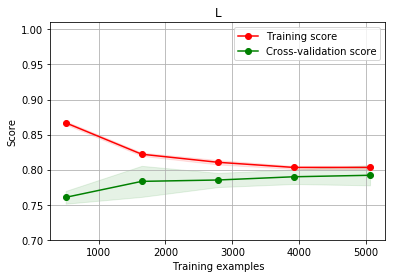

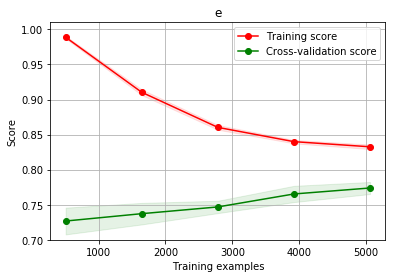

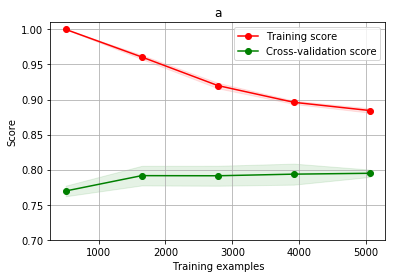

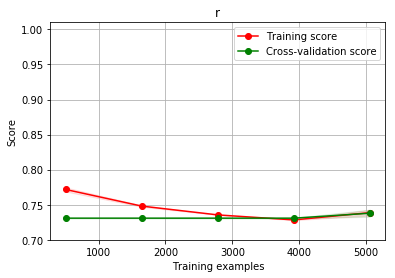

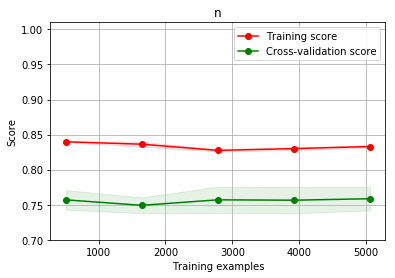

In [94]:
titles = []
estimators = []

#Decision Tree
titles.append(["Learning Curves (Decision Tree, max_depth=5)"])
estimators.append(DecisionTreeClassifier(max_depth=5))

#Nueral Network
titles.append(["Learning Curves (Neural Network, hidden_layer_sizes=(20,))"])
estimators.append(MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20,), random_state=1))

#Boosting
titles.append(["Learning Curves (GradientBoosting, n_estimators=50, max_depth = 6)"])
estimators.append(GradientBoostingClassifier(n_estimators=50, max_depth = 6, random_state = 0))

#SVM
titles.append(["Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"])
estimators.append(SVC(gamma=0.001))

#KNN
titles.append(["Learning Curves (KNN, n=1)"])
estimators.append(KNeighborsClassifier(n_neighbors=5))
i = 0


for estimator in estimators:
    plot_learning_curve(estimator, title[i], X_train, y_train, (0.7,1.01), cv=10, n_jobs=-1)
    i +=1
plt.show()

In [68]:
# Import Scoring Metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

#Create num_train_samples to use in learning curve
percentages = np.linspace(.001,1.0,199, endpoint=True)
num_train_samples = [int(i*len(X_train)) for i in percentages]


#### - Decision Tree
Learning curve: # Train samples
Complexity curve: Max_depth

Text(0,0.5,'Cross-Validated Accuracy')

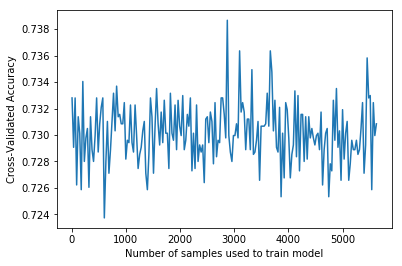

In [69]:
from sklearn.tree import DecisionTreeClassifier  
#http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
dtree_scores = []
for x in num_train_samples:   
    dtree = DecisionTreeClassifier(max_depth=None) 
    scores = cross_val_score(dtree, X_train, y_train, cv=5, scoring='accuracy')
    dtree_scores.append(scores.mean())

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(num_train_samples, dtree_scores)
plt.xlabel('Number of samples used to train model')
plt.ylabel('Cross-Validated Accuracy')

In [70]:


def decision_tree(X_train, X_test, y_train, y_test, max_depth=None):
    dtree = DecisionTreeClassifier(max_depth=max_depth)  
    #print(dtree)
    
    start_time = timeit.default_timer()
    dtree.fit(X_train, y_train) 
    fit_time = timeit.default_timer() - start_time
    
    start_time1 = timeit.default_timer()
    y_pred = dtree.predict(X_test)
    pred_time = timeit.default_timer() - start_time1
    
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, fit_time, pred_time

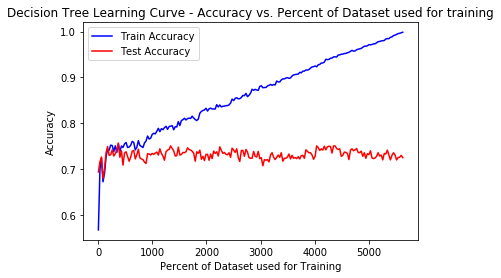

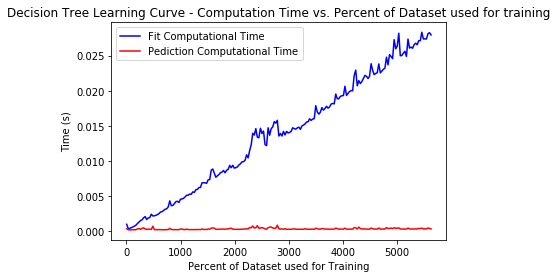

In [71]:
# Learning curve based off of number of Samples in training set
train_results, test_results, fit_time_results, pred_time_results= [],[],[],[]

for x in num_train_samples:
    test_accuracy, test_fit_time, test_pred_time = decision_tree(X_train[:x], X_test, y_train[:x], y_test)
    test_results.append(test_accuracy)
    fit_time_results.append(test_fit_time)
    pred_time_results.append(test_pred_time)
    
    train_accuracy, train_fit_time, train_pred_time = decision_tree(X_train[:x], X_train, y_train[:x], y_train)
    train_results.append(train_accuracy)

plt.figure(0)
line1, = plt.plot(num_train_samples, train_results, 'b')
line2, = plt.plot(num_train_samples, test_results, 'r')
plt.ylabel('Accuracy')
plt.xlabel('Percent of Dataset used for Training')
plt.title('Decision Tree Learning Curve - Accuracy vs. Percent of Dataset used for training')
plt.legend(["Train Accuracy","Test Accuracy"])
plt.show()

plt.figure(1)
plt.plot(num_train_samples, fit_time_results, 'b')
plt.plot(num_train_samples, pred_time_results, 'r')
plt.ylabel('Time (s)')
plt.xlabel('Percent of Dataset used for Training')
plt.title('Decision Tree Learning Curve - Computation Time vs. Percent of Dataset used for training')
plt.legend(["Fit Computational Time", "Pediction Computational Time"])
plt.show()

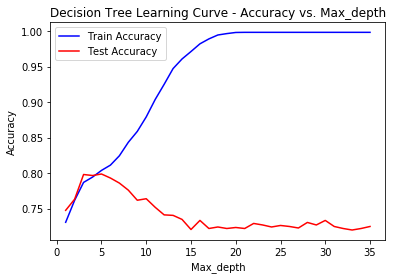

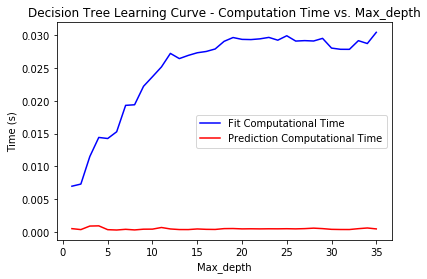

In [72]:
# Learning curve based off of number of Samples in training set
depths = np.linspace(1, 35, 35, endpoint=True)
train_results, test_results, fit_time_results, pred_time_results= [],[],[],[]

for depth in depths:
    test_accuracy, test_fit_time, test_pred_time = decision_tree(X_train, X_test, y_train, y_test, max_depth=depth)
    test_results.append(test_accuracy)
    fit_time_results.append(test_fit_time)
    pred_time_results.append(test_pred_time)
    
    train_accuracy, train_fit_time, train_pred_time = decision_tree(X_train, X_train, y_train, y_train, max_depth=depth)
    train_results.append(train_accuracy)

plt.figure(0)
plt.plot(depths, train_results, 'b')
plt.plot(depths, test_results, 'r')
plt.ylabel('Accuracy')
plt.xlabel('Max_depth')
plt.title('Decision Tree Learning Curve - Accuracy vs. Max_depth')
plt.legend(["Train Accuracy", "Test Accuracy"])
plt.show()

plt.figure(1)
plt.plot(depths, fit_time_results, 'b', label="Fit Computational Time")
plt.plot(depths, pred_time_results, 'r', label="Prediction Computational Time")
plt.ylabel('Time (s)')
plt.xlabel('Max_depth')
plt.title('Decision Tree Learning Curve - Computation Time vs. Max_depth')
plt.legend(["Fit Computational Time", "Prediction Computational Time"])
plt.show()

In [12]:
def decision_tree_auc(X_train, X_test, y_train, y_test, max_depth):
    dtree = DecisionTreeClassifier(max_depth=max_depth)  
    dtree.fit(X_train, y_train) 
    y_pred = dtree.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    return roc_auc

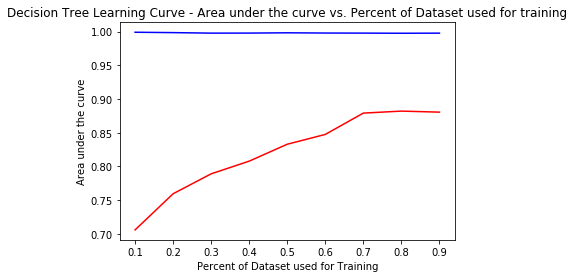

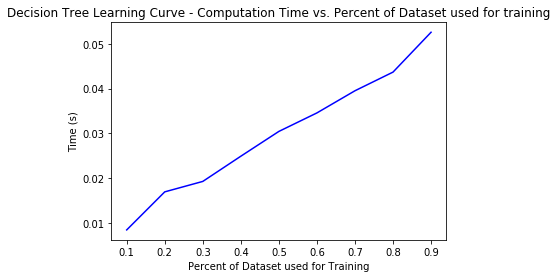

In [13]:
# Learning curve based off of number of Samples in training set
test_percentages = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
train_percentages = [.9,.8,.7,.6,.5,.4,.3,.2,.1]
train_results = []
test_results = []
time_results = []
for percent in test_percentages:
    X_train, X_test, y_train, y_test = train_test_split(xdata, ydata, test_size=percent, random_state=101)
    start_time = timeit.default_timer()
    test_acc = decision_tree_auc(X_train, X_test, y_train, y_test, max_depth=35)
    time_results.append(timeit.default_timer() - start_time)
    test_results.append(test_acc)
    train_results.append(decision_tree_auc(X_train, X_train, y_train, y_train, max_depth=35))

plt.figure(0)
line1, = plt.plot(train_percentages, train_results, 'b', label="Train Accuracy")
line2, = plt.plot(train_percentages, test_results, 'r', label="Test Accuracy")
plt.ylabel('Area under the curve')
plt.xlabel('Percent of Dataset used for Training')
plt.title('Decision Tree Learning Curve - Area under the curve vs. Percent of Dataset used for training')
plt.show()

plt.figure()
plt.plot(train_percentages, time_results, 'b', label="Train Accuracy")
plt.ylabel('Time (s)')
plt.xlabel('Percent of Dataset used for Training')
plt.title('Decision Tree Learning Curve - Computation Time vs. Percent of Dataset used for training')
plt.show()

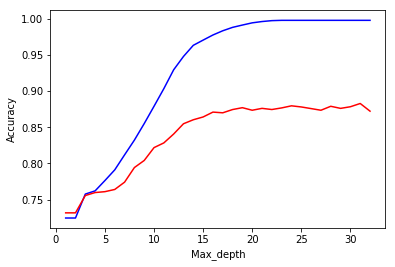

In [14]:
# Learning curve based off of number of Samples in training set
depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
train_auc_results = []
test_auc_results = []
X_train, X_test, y_train, y_test = train_test_split(xdata, ydata, test_size=.3, random_state=101)
for depth in depths:
    start_time = timeit.default_timer()
    test_acc = decision_tree(X_train, X_test, y_train, y_test, max_depth=depth)
    elapsed = timeit.default_timer() - start_time
    #print('This "{name}" took {time} seconds to complete.'.format(name='decision tree', time=elapsed))
    test_results.append(test_acc)
    test_auc_results.append(decision_tree_auc(X_train, X_test, y_train, y_test, max_depth=depth))
    
    train_results.append(decision_tree(X_train, X_train, y_train, y_train, max_depth=depth))
    train_auc_results.append(decision_tree_auc(X_train, X_train, y_train, y_train, max_depth=depth))

line1, = plt.plot(depths, train_auc_results, 'b', label="Train Accuracy")
line2, = plt.plot(depths, test_auc_results, 'r', label="Test Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Max_depth')
plt.show()

#### - Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier
hidden_layer_sizes = [20,40,60,80,100,120,140,160,180,200,250]
X_train, X_test, y_train, y_test = train_test_split(xdata, ydata, test_size=.3, random_state=101)
# train_results = []
# test_results = []
# for hidden_layer_size in hidden_layer_sizes:
#     NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(hidden_layer_size,), random_state=1)
#     NN.fit(X_train, y_train)
#     y_pred = NN.predict(X_train)
#     train_results.append(accuracy_score(y_train, y_pred))
    
#     y_pred = NN.predict(X_test)
#     test_results.append(accuracy_score(y_test, y_pred))
    
# plt.figure(0)
# plt.plot(hidden_layer_sizes, train_results, 'b')
# plt.plot(hidden_layer_sizes, test_results, 'r')
# plt.ylabel('Accuracy')
# plt.xlabel('Number of Hidden Layers')
# plt.title('Neural Network Learning Curve - Accuracy vs. Number of Hidden Layers')
# plt.legend(["Train Accuracy","Test Accuracy"])
# plt.show()

In [ ]:
train_results = []
test_results = []
num_train_samples = [10,20,30,50,100,300,600,1200,2500,4000,5000,6000,7000]
X_train, X_test, y_train, y_test = train_test_split(xdata, ydata, test_size=.3, random_state=101)
for x in num_train_samples:
    num_train_samples.append(x)
    NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20,), random_state=1)
    NN.fit(X_train[:x], y_train[:x])
    y_pred = NN.predict(X_train)
    train_results.append(accuracy_score(y_train, y_pred))
    
    y_pred = NN.predict(X_test)
    test_results.append(accuracy_score(y_test, y_pred))
    
plt.figure(0)
plt.plot(num_train_samples, train_results, 'b')
plt.plot(num_train_samples, test_results, 'r')
plt.ylabel('Accuracy')
plt.xlabel('Number of training samples used for Training')
plt.title('Neural Network Learning Curve - Accuracy vs. Number of training samples used for training')
plt.legend(["Train Accuracy","Test Accuracy"])
plt.show()

#### - Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

train_results = []
test_results = []
num_train_samples = []
X_train, X_test, y_train, y_test = train_test_split(xdata, ydata, test_size=.3, random_state=101)
gb = GradientBoostingClassifier(n_estimators=100, max_depth = 25, random_state = 0)
for x in range(1000, len(X_train)):
    num_train_samples.append(x)
    gb.fit(X_train[:x], y_train[:x])
    y_pred = gb.predict(X_train)
    train_results.append(accuracy_score(y_train, y_pred))
    
    y_pred = gb.predict(X_test)
    train_results.append(accuracy_score(y_test, y_pred))
    
plt.figure(0)
plt.plot(num_train_samples, train_results, 'b')
plt.plot(num_train_samples, test_results, 'r')
plt.ylabel('Accuracy')
plt.xlabel('Number of training samples used for Training')
plt.title('Boosting - Accuracy vs. Number of training samples used for training')
plt.legend(["Train Accuracy","Test Accuracy"])
plt.show()

In [ ]:
train_results = []
test_results = []
num_estimators = np.linspace(1, 200, 200, endpoint=True)
for x in num_estimators:
    gb = GradientBoostingClassifier(n_estimators=x, max_depth = 25, random_state = 0)
    num_train_samples.append(x)
    gb.fit(X_train[:x], y_train[x:])
    y_pred = gb.predict(X_train)
    train_results.append(accuracy_score(y_train, y_pred))
    
    y_pred = gb.predict(X_test)
    train_results.append(accuracy_score(y_test, y_pred))
    
plt.figure(0)
plt.plot(num_estimators, train_results, 'b')
plt.plot(num_estimators, test_results, 'r')
plt.ylabel('Accuracy')
plt.xlabel('Number of training samples used for Training')
plt.title('Boosting - Accuracy vs. Number of estimators')
plt.legend(["Train Accuracy","Test Accuracy"])
plt.show()

#### - Support Vector Machine

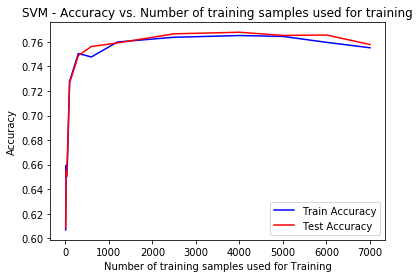

In [21]:
from sklearn.svm import SVC
 
train_results = []
test_results = []
num_train_samples = [10,20,30,50,100,300,600,1200,2500,4000,5000,6000,7000]
svm = SVC(kernel='linear')

for x in num_train_samples:
    svm.fit(X_train[:x],y_train[:x])
    y_pred = svm.predict(X_train)
    train_results.append(accuracy_score(y_train, y_pred))
    
    y_pred = svm.predict(X_test)
    test_results.append(accuracy_score(y_test, y_pred))
    
plt.figure(0)
plt.plot(num_train_samples, train_results, 'b')
plt.plot(num_train_samples, test_results, 'r')
plt.ylabel('Accuracy')
plt.xlabel('Number of training samples used for Training')
plt.title('SVM - Accuracy vs. Number of training samples used for training')
plt.legend(["Train Accuracy","Test Accuracy"])
plt.show()

[0.737825124515772, 0.753458771444383, 0.7542888765910348, 0.7545655783065855, 0.7545655783065855]
[0.7440284054228534, 0.7579083279535184, 0.7562943834732085, 0.7559715945771466, 0.7562943834732085]


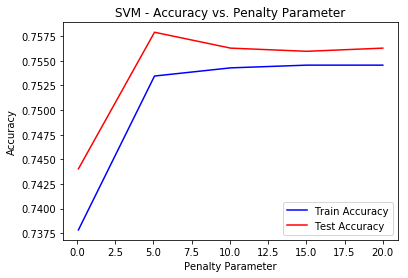

In [28]:
train_results = []
test_results = []
C = np.linspace(.1, 20, 5, endpoint=True)


for c in C:
    svm = SVC(kernel='linear', C=c)
    svm.fit(X_train,y_train)
    y_pred = svm.predict(X_train)
    train_results.append(accuracy_score(y_train, y_pred))
    
    y_pred = svm.predict(X_test)
    test_results.append(accuracy_score(y_test, y_pred))

print(train_results)
print(test_results)
plt.figure(0)
plt.plot(C, train_results, 'b')
plt.plot(C, test_results, 'r')
plt.ylabel('Accuracy')
plt.xlabel('Penalty Parameter')
plt.title('SVM - Accuracy vs. Penalty Parameter')
plt.legend(["Train Accuracy","Test Accuracy"])
plt.show()

#### -  K-NN

In [79]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


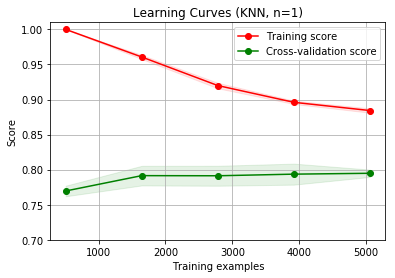

In [92]:

title = "Learning Curves (KNN, n=1)"
svm = SVC(gamma=0.001)
knn = KNeighborsClassifier(n_neighbors=5)
gb = GradientBoostingClassifier(n_estimators=50, max_depth = 6, random_state = 0)
NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20,), random_state=1)
dtree = DecisionTreeClassifier(max_depth=5) 
plot_learning_curve(gb, title, X_train, y_train, (0.7,1.01), cv=10, n_jobs=-1)

plt.show()

In [73]:
from sklearn.model_selection import GridSearchCV

In [75]:
# define the parameter values that should be searched
k_range = list(range(1, 61))

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)

# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=True, n_jobs = -1)

# fit the grid with data
grid.fit(X_train, y_train)

pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.715378,0.015274,{'n_neighbors': 1}
1,0.751289,0.008583,{'n_neighbors': 2}
2,0.748978,0.017368,{'n_neighbors': 3}
3,0.761422,0.011400,{'n_neighbors': 4}
4,0.758400,0.017330,{'n_neighbors': 5}
5,0.768889,0.010894,{'n_neighbors': 6}
6,0.762311,0.015296,{'n_neighbors': 7}
7,0.769244,0.011230,{'n_neighbors': 8}
8,0.768889,0.013038,{'n_neighbors': 9}
9,0.774756,0.011960,{'n_neighbors': 10}


In [76]:
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'mean_train_score', 'params']]

,mean_test_score,mean_train_score,params
0,0.715378,0.998242,{'n_neighbors': 1}
1,0.751289,0.861570,{'n_neighbors': 2}
2,0.748978,0.859437,{'n_neighbors': 3}
3,0.761422,0.836207,{'n_neighbors': 4}
4,0.758400,0.833027,{'n_neighbors': 5}
5,0.768889,0.824731,{'n_neighbors': 6}
6,0.762311,0.820207,{'n_neighbors': 7}
7,0.769244,0.815822,{'n_neighbors': 8}
8,0.768889,0.813887,{'n_neighbors': 9}
9,0.774756,0.813215,{'n_neighbors': 10}


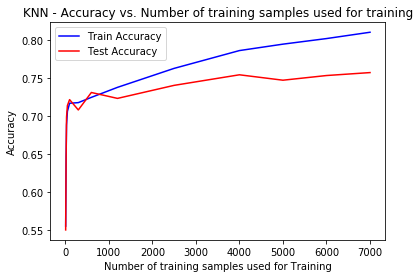

In [14]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

train_results = []
test_results = []
num_train_samples = [10,20,30,50,100,300,600,1200,2500,4000,5000,6000,7000]
knn = KNeighborsClassifier(n_neighbors=7)

for x in num_train_samples:
    knn.fit(X_train[:x],y_train[:x])
    y_pred = knn.predict(X_train)
    train_results.append(accuracy_score(y_train, y_pred))
    
    y_pred = knn.predict(X_test)
    test_results.append(accuracy_score(y_test, y_pred))
    
plt.figure(0)
plt.plot(num_train_samples, train_results, 'b')
plt.plot(num_train_samples, test_results, 'r')
plt.ylabel('Accuracy')
plt.xlabel('Number of training samples used for Training')
plt.title('KNN - Accuracy vs. Number of training samples used for training')
plt.legend(["Train Accuracy","Test Accuracy"])
plt.show()

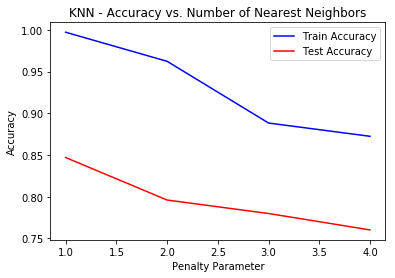

In [18]:
train_results = []
test_results = []
num_neighbors = np.linspace(1, 4, 4, endpoint=True)


for n in num_neighbors:
    knn = KNeighborsClassifier(n_neighbors=int(n))
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_train)
    train_results.append(accuracy_score(y_train, y_pred))
    
    y_pred = knn.predict(X_test)
    test_results.append(accuracy_score(y_test, y_pred))
    
plt.figure(0)
plt.plot(num_neighbors, train_results, 'b')
plt.plot(num_neighbors, test_results, 'r')
plt.ylabel('Accuracy')
plt.xlabel('Penalty Parameter')
plt.title('KNN - Accuracy vs. Number of Nearest Neighbors')
plt.legend(["Train Accuracy","Test Accuracy"])
plt.show()